### Pruning keras models using custom layers:
Using the parameters involved in the intial network training, the aim is to prune the trained network. Pruning here implies that we are going to *zero-out* the non-significant weights (the numbers of which depend on the sparsity percentage). 
Retraining is an essential step to test the efficiency of the pruned network. It compendates for any drop in performance that might be a consequence of pruning the network. During retraining, the pruned weights will not be updated. 

We will keep the training params (except the number of epochs which will be significantly less than the epochs in the intial training of the network) constant during retraining the model.

In [1]:
import os
import sys
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import activations
from tensorflow.python.framework import tensor_shape
from tensorflow.python.keras.engine.base_layer import Layer
from tensorflow.python.keras.engine import base_layer_utils
from keras.layers import Dense, BatchNormalization, Activation,Input, Multiply
from keras import initializers, optimizers, losses, regularizers
from tensorflow.keras.models import model_from_json, load_model
from nn_globals import *
import datetime
from nn_models import (save_my_model, update_keras_custom_objects, lr_decay)
from nn_encode_displ import nlayers, nvariables
from nn_logging import getLogger
from sklearn.model_selection import train_test_split
print(tf.__version__)

# Setup matplotlib
plt.style.use('tdrstyle.mplstyle')

from nn_plotting import (gaus, fit_gaus, np_printoptions, \
                         find_efficiency_errors)

eps = 1e-7
my_cmap = plt.cm.viridis
my_cmap.set_under('w',1)
my_palette = ("#377eb8", "#e41a1c", "#984ea3", "#ff7f00", "#4daf4a")

[INFO    ] Using numpy 1.21.0
[INFO    ] Using tensorflow 2.4.1
[INFO    ] Using keras 2.4.3
[INFO    ] Using scipy 1.7.0
[INFO    ] Using sklearn 0.24.2


2.4.1


<ipython-input-1-80e548dbaef4>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  my_cmap.set_under('w',1)


In [2]:
infile_muon_displ = "NN_input_params_FlatXYZ.npz"

nentries = 100000000

def _handle_nan_in_x(x):
    x[np.isnan(x)] = 0.0
    x[x==-999.0] = 0.0
    return x

def _zero_out_x(x):
    x = 0.0
    return x
    
def _fixME1Ring(x):
    for i in range(len(x)):
        if (x[i,0] != 0.0): x[i,18] = x[i,18] + 1
    return x   

def muon_data(filename, reg_pt_scale=1.0, reg_dxy_scale=1.0, correct_for_eta=False):
    try:
        logger.info('Loading muon data from {0} ...'.format(filename))
        loaded = np.load(filename)
        the_variables = loaded['variables']
        the_parameters = loaded['parameters']
        # print(the_variables.shape)
        the_variables = the_variables[:nentries]
        the_parameters = the_parameters[:nentries]
        logger.info('Loaded the variables with shape {0}'.format(the_variables.shape))
        logger.info('Loaded the parameters with shape {0}'.format(the_parameters.shape))
    except:
        logger.error('Failed to load data from file: {0}'.format(filename))

    assert(the_variables.shape[0] == the_parameters.shape[0])
    _handle_nan_in_x(the_variables)
      #_fixME1Ring(the_variables)
    _handle_nan_in_x(the_parameters)
    mask = np.logical_or(np.logical_or( np.logical_or((the_variables[:,23] == 11), (the_variables[:,23] == 13)), (the_variables[:,23] == 14)),(the_variables[:,23] == 15)) 

    the_variables = the_variables[mask]  
    the_parameters = the_parameters[mask]  
    assert(the_variables.shape[0] == the_parameters.shape[0])

    x = the_variables[:,0:23]
    y = reg_pt_scale*the_parameters[:,0]
    phi = the_parameters[:,1] 
    eta = the_parameters[:,2] 
    vx = the_parameters[:,3] 
    vy = the_parameters[:,4] 
    vz = the_parameters[:,5]      
    dxy = vy * np.cos(phi) - vx * np.sin(phi) 
    dz = vz
    w = np.abs(y)/0.2 + 1.0
    x_mask = the_parameters[:,5]
    x_road = the_parameters[:,5] 
    _zero_out_x(x_mask)
    _zero_out_x(x_road)  
    logger.info('Loaded the encoded variables with shape {0}'.format(x.shape))
    logger.info('Loaded the encoded parameters with shape {0}'.format(y.shape))

    return x, y, dxy, dz, w, x_mask, x_road

def muon_data_split(filename, reg_pt_scale=1.0, reg_dxy_scale=1.0, test_size=0.5, correct_for_eta=False):
    x, y, dxy, dz, w, x_mask, x_road = muon_data(filename, reg_pt_scale=reg_pt_scale, reg_dxy_scale=reg_dxy_scale, correct_for_eta=correct_for_eta)

    # Split dataset in training and testing
    x_train, x_test, y_train, y_test, dxy_train, dxy_test, dz_train, dz_test, w_train, w_test, x_mask_train, x_mask_test, x_road_train, x_road_test = train_test_split(x, y, dxy, dz, w, x_mask, x_road, test_size=test_size)
    logger.info('Loaded # of training and testing events: {0}'.format((x_train.shape[0], x_test.shape[0])))

    # Check for cases where the number of events in the last batch could be too few
    validation_split = 0.1
    train_num_samples = int(x_train.shape[0] * (1.0-validation_split))
    val_num_samples = x_train.shape[0] - train_num_samples
    batch_size = 128
    if (train_num_samples%batch_size) < 100:
        logger.warning('The last batch for training could be too few! ({0}%{1})={2}. Please change test_size.'.format(train_num_samples, batch_size, train_num_samples%batch_size))
        logger.warning('Try this formula: int(int({0}*{1})*{2}) % 128'.format(x.shape[0], 1.0-test_size, 1.0-validation_split))
    train_num_samples = int(x_train.shape[0] * 2 * (1.0-validation_split))
    val_num_samples = x_train.shape[0] - train_num_samples
    batch_size = 128
    if (train_num_samples%batch_size) < 100:
        logger.warning('The last batch for training after mixing could be too few! ({0}%{1})={2}. Please change test_size.'.format(train_num_samples, batch_size, train_num_samples%batch_size))
        logger.warning('Try this formula: int(int({0}*{1})*2*{2}) % 128'.format(x.shape[0], 1.0-test_size, 1.0-validation_split))
    return x_train, x_test, y_train, y_test, dxy_train, dxy_test, dz_train, dz_test, w_train, w_test, x_mask_train, x_mask_test, x_road_train, x_road_test

# Import muon data
# 'x' is the array of input variables, 'y' is the q/pT
x_train_displ, x_test_displ, y_train_displ, y_test_displ, dxy_train_displ, dxy_test_displ, dz_train_displ, dz_test_displ, \
w_train_displ, w_test_displ, x_mask_train_displ, x_mask_test_displ, x_road_train_displ, x_road_test_displ = \
      muon_data_split(infile_muon_displ, reg_pt_scale=reg_pt_scale, reg_dxy_scale=reg_dxy_scale, test_size=0.315)

y_train_displ = np.abs(y_train_displ)
y_test_displ = np.abs(y_test_displ)

x = np.concatenate((x_train_displ, x_test_displ),axis = 0)
y = np.concatenate((y_train_displ, y_test_displ),axis = 0)
dxy = np.concatenate((dxy_train_displ, dxy_test_displ),axis = 0)

[INFO    ] Loading muon data from NN_input_params_FlatXYZ.npz ...
[INFO    ] Loaded the variables with shape (19300000, 25)
[INFO    ] Loaded the parameters with shape (19300000, 6)
[INFO    ] Loaded the encoded variables with shape (3284620, 23)
[INFO    ] Loaded the encoded parameters with shape (3284620,)
[INFO    ] Loaded # of training and testing events: (2249964, 1034656)
[WARNING ] The last batch for training could be too few! (2024967%128)=7. Please change test_size.
[WARNING ] Try this formula: int(int(3284620*0.685)*0.9) % 128
[WARNING ] The last batch for training after mixing could be too few! (4049935%128)=15. Please change test_size.
[WARNING ] Try this formula: int(int(3284620*0.685)*2*0.9) % 128


In [3]:
class evaluate:
    def __init__(self,X_test,y_test):
        self.X = X_test
        self.y = y_test[0]
        self.dxy = y_test[1]
    
    def compute_data_statistics(self,ctype = "y",label="data"):
        if ctype == "y":
            x = self.recalibrate(self.y,reg_pt_scale)
            x = x**(-1)
        else:
            x = self.recalibrate(self.dxy,reg_dxy_scale)
        df_describe = pd.DataFrame(x, columns = [label])
        print(df_describe.describe())
    
    def rmse(self,y_true, y_predicted):
        assert(y_true.shape[0] == y_predicted.shape[0])
        n = y_true.shape[0]
        sum_square = np.sum((y_true - y_predicted)**2)
        return math.sqrt(sum_square/n)
    
    def adjusted_r_2(self,y_true, y_predicted):
        y_addC = sm.add_constant(y_true)
        result = sm.OLS(y_predicted, y_addC).fit()
        print(result.rsquared, result.rsquared_adj)

    def recalibrate(self,x,scale):
        return x/scale
    
    def inverse(self,arr):
        arr_inv = 1./arr
        arr_inv[arr_inv == np.inf] = 0.
        return arr_inv
    
    def predict(self,model,batch_size = 256):
        y_test_true = self.recalibrate(self.y,reg_pt_scale)
        dxy_test_true = self.recalibrate(self.dxy, reg_dxy_scale)
        
        y_test = model.predict(self.X,batch_size = batch_size)
        y_test_meas = y_test[:,0]
        dxy_test_meas = y_test[:,1]
        y_test_meas = self.recalibrate(y_test_meas,reg_pt_scale)
        dxy_test_meas = self.recalibrate(dxy_test_meas,reg_dxy_scale)   
    
        y_test_meas = y_test_meas.reshape(-1)
        dxy_test_meas = dxy_test_meas.reshape(-1)

        return y_test_meas, dxy_test_meas
    
    def compute_error(self,y_predicted,ctype = "y"):
        if ctype == "y":
            y_test_true = self.recalibrate(self.y,reg_pt_scale)
            print("RMSE Error for momentum:",self.rmse(self.inverse(y_test_true),\
                                                                              self.inverse(y_predicted)))
        else:
            dxy_test_true = self.recalibrate(self.dxy, reg_dxy_scale)
            print("RMSE Error for dxy:",self.rmse(dxy_test_true,y_predicted))

    def get_error(self,y_predicted,ctype = "y"):
        if ctype == "y":
            y_test_true = self.recalibrate(self.y,reg_pt_scale)
            return self.rmse(self.inverse(y_test_true),self.inverse(y_predicted))
        else:
            dxy_test_true = self.recalibrate(self.dxy, reg_dxy_scale)
            return self.rmse(dxy_test_true,y_predicted)

def k_fold_validation(model, x, y, dxy, folds =10):
    x_copy = np.copy(x)
    y_copy = np.copy(y)
    dxy_copy = np.copy(dxy)
    assert x_copy.shape[0] == y_copy.shape[0] == dxy_copy.shape[0]
    fold_size = int(x_copy.shape[0] / folds)
    x_splits, y_splits, dxy_splits = [], [], []
    for i in range(folds):
        indices = np.random.choice(x_copy.shape[0],fold_size, replace=False)  
        x_splits.append(x_copy[indices])
        y_splits.append(y_copy[indices])
        dxy_splits.append(dxy_copy[indices])
        x_copy = np.delete(x_copy,indices,axis = 0)
        y_copy = np.delete(y_copy,indices,axis = 0)
        dxy_copy = np.delete(dxy_copy,indices,axis = 0)
    rmse_y, rmse_dxy = [],[]
    for i in range(folds):
        evaluate_obj = evaluate(x_splits[i], tuple([y_splits[i],dxy_splits[i]]))
        y_predicted , dxy_predicted = evaluate_obj.predict(model = model)
        rmse_y.append(evaluate_obj.get_error(y_predicted,ctype="y"))
        rmse_dxy.append(evaluate_obj.get_error(dxy_predicted,ctype="dxy"))
    print('Average RMSE for '+ str(folds) + '-fold cv for y:', np.mean(rmse_y))
    print('Average RMSE for '+ str(folds) + '-fold cv for dxy:', np.mean(rmse_dxy))
    
def huber_loss(y_true, y_pred, delta=1.345):
    x = K.abs(y_true - y_pred)
    squared_loss = 0.5*K.square(x)
    absolute_loss = delta * (x - 0.5*delta)
    #xx = K.switch(x < delta, squared_loss, absolute_loss)
    xx = tf.where(x < delta, squared_loss, absolute_loss)  # needed for tensorflow
    return K.mean(xx, axis=-1)

def get_sparsity(weights):
    """
    Code borrowed from https://github.com/google/qkeras/blob/master/qkeras/utils.py#L937
    Returns the sparsity as the ratio of non-zero weights to the total weights within the weights matrix.
    """
    return 1.0 - np.count_nonzero(weights) / float(weights.size)

In [4]:
def generate_pruning_mask(k_weights, k_sparsity):
    """
    Takes in matrix of kernel weights (for a dense
      layer) and returns the pruning mask for it
    Args:
      k_weights: 2D matrix of the weights
      k_sparsity: percentage of weights to set to 0
    Returns:
      kernel_weights_mask: sparse matrix with same shape as the original
        kernel weight matrix
    """
    # Copy the kernel weights and get ranked indeces of the abs
    kernel_weights_mask = np.ones(shape=k_weights.shape)
    ind = np.unravel_index(
                        np.argsort(
                            np.abs(k_weights),
                            axis=None),
                        k_weights.shape)
        
    # Number of indexes to set to 0
    cutoff = int(len(ind[0])*k_sparsity)
    # The indexes in the 2D kernel weight matrix to set to 0
    sparse_cutoff_inds = (ind[0][0:cutoff], ind[1][0:cutoff])
    kernel_weights_mask[sparse_cutoff_inds] = 0.
    return kernel_weights_mask
    
def generate_layer_masks(init_model,k_sparsity = 0.5):
    """
    Takes in a model made of dense layers and prunes the weights
    Args:
      model: Keras model
      k_sparsity: target sparsity of the model
    Returns:
      List of mask for each of dense layers
    """
    # Getting a list of the names of each component (w + b) of each layer
    names = [weight.name for layer in init_model.layers for weight in layer.weights]
    # Getting the list of the weights for weight of each layer
    weights = init_model.get_weights()
    
    # Initializing list that will contain the new sparse weights
    newMaskList = []
    
   # Iterate over all dense layers but the final layer
    for i in range(0,len(weights)-2,1):
        if len(weights[i].shape) == 2:  
            mask = generate_pruning_mask(weights[i],k_sparsity)
            newMaskList.append(mask)
    return newMaskList

In [5]:
# load json and create model
def loading_trained_model(filepath='', model_filename='model'):
    try:
        model_path = filepath + model_filename + ".json"
        model_weights_path = filepath + model_filename + "_weights.h5"
        json_file = open(model_path, 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        loaded_model = model_from_json(loaded_model_json)
        # load weights into new model
        loaded_model.load_weights(model_weights_path)
        print("Loaded model from disk")
        
        return loaded_model
        
    except:
        print("ERROR: The model doesn't exist at the address provided.")
        
loaded_model = loading_trained_model(filepath = os.getcwd()+"/",model_filename = 'model')

Loaded model from disk


In [6]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 23)                92        
_________________________________________________________________
dense (Dense)                (None, 20)                460       
_________________________________________________________________
batch_normalization_1 (Batch (None, 20)                80        
_________________________________________________________________
activation (Activation)      (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 15)                300       
_________________________________________________________________
batch_normalization_2 (Batch (None, 15)                60        
_________________________________________________________________
activation_1 (Activation)    (None, 15)                0

In [6]:
class MaskedDense(Layer):
    def __init__(self, units, 
                    mask,
                    activation = None,
                    kernel_initializer = "glorot_uniform",
                    bias_initializer = None,
                    kernel_regularizer = None,
                    bias_regularizer = None, **kwargs):
        
        self.num_outputs = units
        self.layer_mask = tf.convert_to_tensor(mask, dtype = K.floatx())
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activation = activations.get(activation)
        super(MaskedDense, self).__init__(**kwargs)

    def get_config(self):

        config = {
            'units': self.num_outputs,
            'mask': self.layer_mask.numpy(),
            'kernel_initializer': self.kernel_initializer,
            'bias_initializer': self.bias_initializer,
            'kernel_regularizer': self.kernel_regularizer,
            'bias_regularizer': self.bias_regularizer,
            'activation': self.activation
        }
        base_config = super(MaskedDense, self).get_config()
        return dict(list(base_config.items()) + list(config.items())) 
    
#     @classmethod
#     def from_config(cls, config):
#         return cls(**config)
    
    def build(self, input_shape):
        
        last_dim = int(input_shape[-1])  
        self.kernel = self.add_weight("kernel",
                                    shape = (last_dim,self.num_outputs),
                                    initializer=self.kernel_initializer,
                                    regularizer=self.kernel_regularizer,
                                    dtype=K.floatx(),
                                    trainable=True)

        super(MaskedDense, self).build(input_shape)
        self.built = True
    
    def call(self, inputs):
        if not self.activation:
            return tf.matmul(inputs,self.kernel*self.layer_mask)
        else:
            outputs = tf.matmul(inputs,self.kernel*self.layer_mask)
            return self.activation(outputs)
    
    def compute_output_shape(self, input_shape):
        
        input_shape = tensor_shape.TensorShape(input_shape)
        input_shape = input_shape.with_rank_at_least(2)
        if tensor_shape.dimension_value(input_shape[-1]) is None:
            raise ValueError(
                  'The innermost dimension of input_shape must be defined, but saw: %s'
                  % (input_shape,))
        return [int(input_shape[-1]),units]
    
    def set_weights(self, weights):
        params = [self.kernel]

        expected_num_weights = 0
        for param in params:
            if isinstance(param, base_layer_utils.TrackableWeightHandler):
                expected_num_weights += param.num_tensors
            else:
                expected_num_weights += 1
        
        assert expected_num_weights == len(weights)
        
        weight_value_tuples = []
        weight_index = 0
        for param in params:
            # multiplication of input weights to layer mask is necessary to ensure mask is applied to initial kernels
            weight_value_tuples.append((param,weights[weight_index]*self.layer_mask.numpy()))
            weight_index += 1
        
        K.batch_set_value(weight_value_tuples)
        
    def get_weights(self):
        # return a masked kernel to ensure the next one is set 
        return K.batch_get_value([self.kernel*self.layer_mask])
    

In [7]:
class CustomModel:
    @staticmethod
    def build(input_dim, output_dim, masks, layerActivation = "tanh", finalActivation = "linear",
             eps = 1e-4, momentum = 0.9, l1_reg = 0.0, l2_reg = 0.0):
        if l1_reg == 0 and l2_reg == 0:
            regularizer = None
        else:
            regularizer = regularizers.L1L2(l1=l1_reg, l2=l2_reg)
        # input pre-processing layers
        inputs = Input(shape = (input_dim,),name = "input_layer")
        x = BatchNormalization(epsilon = eps, momentum  = momentum, name="batchnorm-1")(inputs)
        # Hidden Masked Dense Unit 1
        x = MaskedDense(units = 20, mask = masks[0],kernel_regularizer=regularizer,
                        name = "masked_dense-1")(x)
        x = BatchNormalization(epsilon = eps, momentum  = momentum, name = "batchnorm-2")(x)
        x = Activation(activation = layerActivation, name = "layer_activation-1")(x)
        # Hidden Masked Dense Unit 2
        x = MaskedDense(units = 15, mask = masks[1],kernel_regularizer=regularizer, 
                        name = "masked_dense-2")(x)
        x = BatchNormalization(epsilon = eps, momentum  = momentum, name = "batchnorm-3")(x)
        x = Activation(activation = layerActivation, name = "layer_activation-2")(x)
        # Hidden Masked Dense Unit 3
        x = MaskedDense(units = 10, mask = masks[2],kernel_regularizer=regularizer,
                        name = "masked_dense-3")(x)
        x = BatchNormalization(epsilon = eps, momentum  = momentum, name = "batchnorm-4")(x)
        x = Activation(activation = layerActivation, name = "layer_activation-3")(x)
        # Output layer
        outputs = Dense(units = output_dim, activation = finalActivation, 
                        use_bias = True, name = "output_dense")(x)  
        model = tf.keras.models.Model(inputs,outputs)
        return model

In [ ]:
# load json and create model
def loading_trained_model(filepath='', model_filename='model'):
    try:
        model_path = filepath + model_filename + ".json"
        model_weights_path = filepath + model_filename + "_weights.h5"
        json_file = open(model_path, 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        loaded_model = model_from_json(loaded_model_json)
        # load weights into new model
        loaded_model.load_weights(model_weights_path)
        print("Loaded model from disk")
        
        return loaded_model
        
    except:
        print("ERROR: The model doesn't exist at the address provided.")
        
loaded_model = loading_trained_model(filepath = os.getcwd()+"/",model_filename = 'model')

In [ ]:
logger = getLogger()
def train_model(model, x, y, model_name='model', save_model = False, batch_size=1, epochs=100, 
                verbose=False, callbacks=None, validation_split=0., shuffle=True, class_weight=None, 
                sample_weight=None):
    
    start_time = datetime.datetime.now()
    logger.info('Begin training ...')

    history = model.fit(x, y, batch_size=batch_size, 
                        epochs=epochs, verbose=verbose, callbacks=callbacks,
                        validation_split=validation_split, shuffle=shuffle, 
                        class_weight=class_weight, sample_weight=sample_weight)

    logger.info('Done training. Time elapsed: {0} sec'.format(str(datetime.datetime.now() - start_time)))
    if save_model:
        save_my_model(model, name=model_name)

    return history

In [ ]:
def train_sparse_model(model, x, y, dxy, k_sparsity = 0.1, retrain_epochs = 10, batch_size = 100, 
                        learning_rate = 1e-4, clipnorm = 0.0, bn_epsilon = 1e-4, bn_momentum = 0.9,
                        l1_reg = 0.0, l2_reg = 0.0, validation_split = 0.2):
    
    if k_sparsity >= 1.0 or k_sparsity <= 0.0:
        raise ValueError("Sparsity can only be within the range of (0.0,1.0) endpoint values not included.")
    
    # generate the masks for pruning
    masksList= generate_layer_masks(init_model = model, k_sparsity = k_sparsity)
    sparse_model = CustomModel.build(input_dim = nvariables, 
                                     output_dim = 2, 
                                     masks = masksList, 
                                     eps = bn_epsilon, 
                                     momentum = bn_momentum,
                                     l1_reg = 0.0, 
                                     l2_reg = 0.0)
    # Load the existing model's weights to the custom model's kernels
    # MaskedDense layer's set_weights() ONLY updates the kernel not the mask
    init_weights = []
    for layer in model.layers:
        init_weights.append(layer.get_weights())
    # If input model is a custom pruned model, the top layer would be an InputLayer
    if isinstance(model.layers[0], keras.layers.InputLayer):
        for i in range(1,len(sparse_model.layers)):
            sparse_model.layers[i].set_weights(init_weights[i])
    else:
        for i in range(1,len(sparse_model.layers)):
            sparse_model.layers[i].set_weights(init_weights[i-1])  

    
    adam = optimizers.Adam(lr=learning_rate, clipnorm=clipnorm)
    sparse_model.compile(optimizer=adam, loss=huber_loss, metrics=['acc'])
    sparse_model.summary()
    
    history = None
    history = train_model(sparse_model, 
                          x, 
                          np.column_stack((y, dxy)),
                          save_model = False, 
                          epochs = retrain_epochs, 
                          batch_size = batch_size,
                          callbacks = [lr_decay], 
                          validation_split= validation_split, 
                          verbose = 2)
    return sparse_model,history

In [ ]:
lr = 1e-4
clipnorm = 10.
eps = 1e-4
momentum = 0.9
epochs = 50
batch_size = 1000 
l1_reg = 0.0
l2_reg = 0.0

sparsity = 0.1
pruned_model_10, training_history_1 = train_sparse_model(loaded_model, x_train_displ, 
                                     y_train_displ, dxy_train_displ,
                                     k_sparsity = sparsity, 
                                     retrain_epochs = epochs, 
                                     batch_size = batch_size, 
                                     learning_rate = lr, 
                                     clipnorm = clipnorm, 
                                     bn_epsilon = eps, 
                                     bn_momentum = momentum,
                                     l1_reg = l1_reg,
                                     l2_reg = l2_reg,
                                     validation_split = 0.1)

In [ ]:
k_fold_validation(model = pruned_model_10, 
                  x = x, 
                  y = y, 
                  dxy = dxy, 
                  folds =50)

In [ ]:
lr = 3e-4
clipnorm = 10.
eps = 1e-4
momentum = 0.9
epochs = 50
batch_size = 1000 
l1_reg = 0.0
l2_reg = 0.0
sparsity = 0.20
pruned_model_20,training_history_2 = train_sparse_model(pruned_model_10, x_train_displ, 
                                     y_train_displ, dxy_train_displ,
                                     k_sparsity = sparsity, 
                                     retrain_epochs = epochs, 
                                     batch_size = batch_size, 
                                     learning_rate = lr, 
                                     clipnorm = clipnorm, 
                                     bn_epsilon = eps, 
                                     bn_momentum = momentum,
                                     l1_reg = l1_reg,
                                     l2_reg = l2_reg,
                                     validation_split = 0.1)

In [ ]:
k_fold_validation(model = pruned_model_20, 
                  x = x, 
                  y = y, 
                  dxy = dxy, 
                  folds =50)

In [ ]:
lr = 2.5e-4
clipnorm = 20.
eps = 1e-4
momentum = 0.9
epochs = 75
batch_size = 1000 
l1_reg = 0.0
l2_reg = 0.0

sparsity = 0.30
pruned_model_30,training_history_3 = train_sparse_model(pruned_model_20, x_train_displ, 
                                     y_train_displ, dxy_train_displ,
                                     k_sparsity = sparsity, 
                                     retrain_epochs = epochs, 
                                     batch_size = batch_size, 
                                     learning_rate = lr, 
                                     clipnorm = clipnorm, 
                                     bn_epsilon = eps, 
                                     bn_momentum = momentum,
                                     l1_reg = l1_reg,
                                     l2_reg = l2_reg,
                                     validation_split = 0.1)

In [ ]:
k_fold_validation(model = pruned_model_30, 
                  x = x, 
                  y = y, 
                  dxy = dxy, 
                  folds =50)

In [ ]:
lr = 5e-4
clipnorm = 10.
eps = 1e-4
momentum = 0.75
epochs = 50
batch_size = 400 
l1_reg = 0.0
l2_reg = 0.0

sparsity = 0.40
pruned_model_40,training_history_4 = train_sparse_model(pruned_model_30, x_train_displ, 
                                     y_train_displ, dxy_train_displ,
                                     k_sparsity = sparsity, 
                                     retrain_epochs = epochs, 
                                     batch_size = batch_size, 
                                     learning_rate = lr, 
                                     clipnorm = clipnorm, 
                                     bn_epsilon = eps, 
                                     bn_momentum = momentum, 
                                     l1_reg = l1_reg,
                                     l2_reg = l2_reg,
                                     validation_split = 0.1)

In [ ]:
k_fold_validation(model = pruned_model_40, 
                  x = x, 
                  y = y, 
                  dxy = dxy, 
                  folds =50)

In [ ]:
lr = 7.5e-4
clipnorm = 10.
eps = 1e-4
momentum = 0.9
epochs = 125
batch_size = 500
l1_reg = 0.0
l2_reg = 0.0
sparsity = 0.50
pruned_model_50,training_history_5 = train_sparse_model(pruned_model_40, x_train_displ, 
                                     y_train_displ, dxy_train_displ,
                                     k_sparsity = sparsity, 
                                     retrain_epochs = epochs, 
                                     batch_size = batch_size, 
                                     learning_rate = lr, 
                                     clipnorm = clipnorm, 
                                     bn_epsilon = eps, 
                                     bn_momentum = momentum, 
                                     l1_reg = l1_reg,
                                     l2_reg = l2_reg,
                                     validation_split = 0.1)

In [ ]:
k_fold_validation(model = pruned_model_50, 
                  x = x, 
                  y = y, 
                  dxy = dxy, 
                  folds =50)

In [ ]:
lr = 3.5e-3
clipnorm = 10.
eps = 1e-4
momentum = 0.9
epochs = 200
batch_size = 500
l1_reg = 0.0
l2_reg = 0.0
sparsity = 0.60

pruned_model_60,training_history_6 = train_sparse_model(pruned_model_50, x_train_displ, 
                                     y_train_displ, dxy_train_displ,
                                     k_sparsity = sparsity, 
                                     retrain_epochs = epochs, 
                                     batch_size = batch_size, 
                                     learning_rate = lr, 
                                     clipnorm = clipnorm, 
                                     bn_epsilon = eps, 
                                     bn_momentum = momentum, 
                                     l1_reg = l1_reg,
                                     l2_reg = l2_reg,
                                     validation_split = 0.1)

In [ ]:
k_fold_validation(model = pruned_model_60, 
                  x = x, 
                  y = y, 
                  dxy = dxy, 
                  folds =50)

### Saving and Loading the custom pruning model:

In [8]:
from keras.initializers import glorot_uniform
from keras.regularizers import l1_l2
import os
import zipfile
import tempfile

In [9]:
def saving_pruned_model(model,filepath='', model_filename='model'):
    # serialize model to JSON
    model_json = model.to_json()
    with open(os.getcwd() + "/" + model_filename + ".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(os.getcwd() + "/" + model_filename + "_weights.h5")
    print("Saved model to disk")

def loading_pruned_model(filepath='', model_filename='model', custom_objects = None):
    try:
        model_path = filepath + "/" + model_filename + ".json"
        print(model_path)
        model_weights_path = filepath + "/" + model_filename + "_weights.h5"
        print(model_weights_path)
        json_file = open(model_path, 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        loaded_model = model_from_json(loaded_model_json, custom_objects = custom_objects)
        # load weights into new model
        loaded_model.load_weights(model_weights_path)
        print("Loaded model from disk")
        
        return loaded_model
        
    except:
        print("ERROR: The model doesn't exist at the address provided.")

In [40]:
def __generate_delta_plots__(model,
                             x,
                             y,
                             dxy,batch_size = 4096):
    
    # Predictions
    y_test_true = y.copy()
    y_test_true /= reg_pt_scale

    y_test_sel = (np.abs(1.0/y) >= 20./reg_pt_scale)

    y_test_meas_ = model.predict(x, batch_size=4096)
    y_test_meas = y_test_meas_[:,0]
    y_test_meas /= reg_pt_scale
    y_test_meas = y_test_meas.reshape(-1)

    dxy_test_true = dxy.copy()
    dxy_test_true /= reg_dxy_scale

    dxy_test_sel = (np.abs(dxy_test_true) >= 25)

    dxy_test_meas = y_test_meas_[:,1]
    dxy_test_meas /= reg_dxy_scale
    dxy_test_meas = dxy_test_meas.reshape(-1)
    
    # Plot Delta(q/pT)/pT
    plt.figure(figsize=(5,5),dpi = 75)
    yy = ((np.abs(1.0/y_test_meas) - np.abs(1.0/y_test_true))/np.abs(1.0/y_test_true))
    hist, edges, _ = plt.hist(yy, bins=100, range=(-2.0,2.0-eps), histtype='stepfilled', facecolor='c', alpha=0.6)
    plt.xlabel(r'$\Delta(p_{T})_{\mathrm{meas-true}}/{(p_{T})}_{true}$ [1/GeV]')
    plt.ylabel(r'entries')
    logger.info('# of entries: {0}, mean: {1}, std: {2}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.4])))

    popt = fit_gaus(hist, edges, mu=np.mean(yy), sig=np.std(yy[np.abs(yy)<2.0]))
    logger.info('gaus fit (a, mu, sig): {0}'.format(popt))
    xdata = (edges[1:] + edges[:-1])/2
    plt.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='c')
    plt.show()

    # Plot Delta(dxy)
    plt.figure(figsize=(5,5),dpi = 75)
    yy = (dxy_test_meas - dxy_test_true)[y_test_sel]
    hist, edges, _ = plt.hist(yy, bins=100, range=(-50,50), histtype='stepfilled', facecolor='c', alpha=0.6)
    plt.xlabel(r'$\Delta(d_{0})_{\mathrm{meas-true}}$ [cm]')
    plt.ylabel(r'entries')
    logger.info('# of entries: {0}, mean: {1}, std: {2}'.format(len(yy), np.mean(yy), np.std(yy)))

    popt = fit_gaus(hist, edges, mu=np.mean(yy), sig=np.std(yy))
    logger.info('gaus fit (a, mu, sig): {0}'.format(popt))
    xdata = (edges[1:] + edges[:-1])/2
    plt.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='c')
    plt.show()

models/custom_model_60.json
models/custom_model_60_weights.h5
Loaded model from disk


[INFO    ] # of entries: 1034656, mean: 0.04914900053785938, std: 0.18575127468817754
[INFO    ] gaus fit (a, mu, sig): [5.27028698e+04 6.66910585e-03 2.58690491e-01]


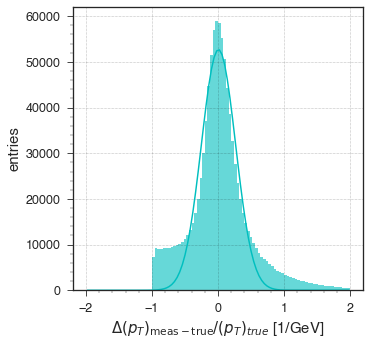

[INFO    ] # of entries: 150036, mean: 0.24718958944385433, std: 10.315857529324528
[INFO    ] gaus fit (a, mu, sig): [9.09409844e+03 2.15688384e-01 5.99455277e+00]


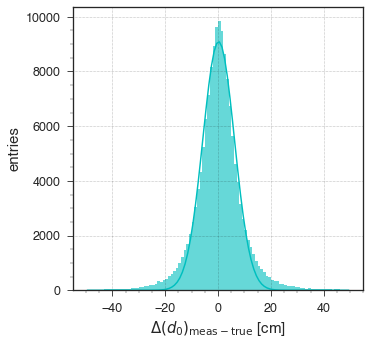

In [41]:
loaded_pruned_model = loading_pruned_model(filepath='models', 
                                           model_filename='custom_model_60', 
                                           custom_objects = {'GlorotUniform': glorot_uniform(), 
                                                        "MaskedDense": MaskedDense, 
                                                        "L1L2": l1_l2()})
__generate_delta_plots__(model = loaded_pruned_model,
                        x = x_test_displ,
                        y = y_test_displ,
                        dxy = dxy_test_displ)

In [33]:
# tf.keras.models.save_model(pruned_model_10, "models/pruned_model_10.h5", include_optimizer=True)
# saving_pruned_model(pruned_model_40,model_filename="models/custom_model_40")

In [22]:
x = np.concatenate((x_train_displ, x_test_displ),axis = 0)
y = np.concatenate((y_train_displ, y_test_displ),axis = 0)
dxy = np.concatenate((dxy_train_displ, dxy_test_displ),axis = 0)

k_fold_validation(model = loaded_pruned_model, 
                  x = x, 
                  y = y, 
                  dxy = dxy, 
                  folds =50)

Average RMSE for 50-fold cv for y: 51.75967984495742
Average RMSE for 50-fold cv for dxy: 16.22979410291915


In [ ]:
def __get_weights__(model,layer_type="dense"):
    weights = dict()
    if layer_type == "dense":
        for layer in model.layers: 
            if layer_type in layer.name:
                weights[layer.name] = layer.get_weights()
    elif layer_type == "all":
        for layer in model.layers:
            weights[layer.name] = layer.get_weights()
    return weights

def __plot_dist__(weights,title="", color = "purple", alpha = 0.5):
    w = np.ndarray.flatten(weights)
    plt.figure(figsize=(5,5),dpi =75)
    plt.hist(w,color=color,alpha = alpha)
    plt.title("weights for layer " + title)
    plt.show()
    
def __layer_statistics__(layer_weights): 
        arr = np.ndarray.flatten(layer_weights)        
        stats = {"min":min(arr),
                 "max": max(arr),
                 "mean": np.mean(arr),
                 "median": np.median(arr),
                 "range":abs(max(arr)-min(arr)),
                 "zeros": (arr==0.).sum(),
                 "negatives": (arr<0.).sum(),
                 "positives":(arr>0.).sum(),
                 "var": np.std(arr)**2
                }
        print(pd.DataFrame.from_dict(stats,orient="index",columns=["measure"]))

In [ ]:
weights = __get_weights__(loaded_pruned_model)
for key, values in weights.items():
    print(key,get_sparsity(values[0]))

In [ ]:
for key, values in weights.items():
    print(key,get_sparsity(values[0]))
    print(values[0][0])
    break

In [ ]:
for key, values in weights.items():
    __plot_dist__(values[0],title = key,color = "cyan", alpha = 0.45)
    __layer_statistics__(values[0])

In [ ]:
# def get_gzipped_model_size(file):
#     """
#     Returns size of gzipped model, in bytes.
#     """
#     _, zipped_file = tempfile.mkstemp('.zip')
#     with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
#         f.write(file)

#     return os.path.getsize(zipped_file)

In [ ]:
# x = [10,20,30,40,50,60]
# for i in range(len(x)):
#     pruned_model_file_h5 = "models/custom_model_" + str(x[i]) 
#     print("Size of gzipped pruned model: %.2f bytes"%(get_gzipped_model_size(pruned_model_file_h5 + ".json")))
    

In [ ]:
#################################################### END-OF-CODE ####################################################